# Deep Residual U-Net (ResUNet)
Paper: https://arxiv.org/pdf/1711.10684.pdf

ResUNet, a semantic segmentation model inspired by the deep residual learning and UNet. An architecture that take advantages from both(Residual and UNet) models.

## 1.1 Advantages
<ol>
    <li>The residual unit will ease the training of the network.</li>
    <li>The skip connections within a residual unit and between low levels and high levels of the network will facilitate information propagation without degradation,making it possible to design a neural network with much fewer
parameters.</li>
</ol>

## 1.2 Architecture

### 1.2.1 Basic Buildig Block
The ResUNet uses Residual Units as basic building block instead of plain convolutional block.
<br/>
<ol>
    <li>Residual units consists of:</li>
<ol>
    <li>Two 3x3 convolutional block.</li>
    <li>An identity mapping.</li>                                 
</ol>

The Identity Mapping connects the input and output of the Residual unit.
<br/><br/>

<li>Convolutional block consists of:</li>
<ol>
    <li>One Batch Normalization layer.</li>
    <li>One ReLU Activation layer.</li>
    <li>One Convolutional layer.</li>
</ol>

</ol>
    
<img src="images/basic block.png">

### 1.2.3 Complete Architecture

The ResUNet consists of three parts:
<ol>
    <li>Encoding</li>
    <li>Bridge</li>
    <li>Decoding</li>
</ol>

<ul>
<li>
In encoding units, instead of using pooling operation to downsample feature map size, a stride of 2 is applied to the first convolution block to reduce the feature map by half.
</li>

<li>
Before each decoding unit, there is an up-sampling of feature maps from lower level and a concatenation with the feature maps from the corresponding encoding path.
</li>

<li>
At last a 1x1 Convolution is applied with Sigmoid activation to obtain a desired segmentation map.
</li>
</ul>

<img src="images/arch.png">

## 1.3 Loss
Mean Squared Error(MSE) is used as the loss function

<img src="images/loss.png">

<ul>
<li>N = Number of training samples</li>
<li>Net(I<sub>w</sub>;W) = Predicted Segmentation Map</li>
<li>s<sub>i</sub> = Ground Tructh Segmentaton Map</li>
</ul>

## 1.4 Result

<img src="images/result.png">

## 1.4 Dataset
Kaggle TGS Salt Identification Challenge: https://www.kaggle.com/c/tgs-salt-identification-challenge

In [1]:
## Imports
import os
import sys
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Path

In [2]:
dataset_path = "dataset/"
train_path = os.path.join(dataset_path, "train/")

## Data Generator

In [3]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, "masks", id_name) + ".png"
        
        ## Reading Image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        ##Reading Mask
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
        
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [4]:
train_csv = pd.read_csv(dataset_path + "train.csv")
train_ids = train_csv["id"].values

image_size = 128
batch_size = 16

val_data_size = 200

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [5]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(16, 128, 128, 3) (16, 128, 128, 1)


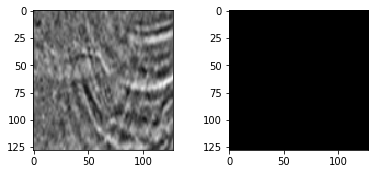

In [8]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r]*255, (image_size, image_size)), cmap="gray")

## Different Blocks

In [9]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

## ResUNet

In [10]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [11]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [12]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 3)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 64          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (

## Training

In [13]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

epochs = 10

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/10
237/237 [==============================] - 40s 168ms/step - loss: 0.4408 - dice_coef: 0.5592 - val_loss: 0.5942 - val_dice_coef: 0.4058
Epoch 2/10
237/237 [==============================] - 22s 93ms/step - loss: 0.3808 - dice_coef: 0.6192 - val_loss: 0.5182 - val_dice_coef: 0.4818
Epoch 3/10
237/237 [==============================] - 22s 94ms/step - loss: 0.3945 - dice_coef: 0.6055 - val_loss: 0.4681 - val_dice_coef: 0.5319
Epoch 4/10
237/237 [==============================] - 23s 96ms/step - loss: 0.3370 - dice_coef: 0.6630 - val_loss: 0.3781 - val_dice_coef: 0.6219
Epoch 5/10
237/237 [==============================] - 23s 96ms/step - loss: 0.3830 - dice_coef: 0.6170 - val_loss: 0.4132 - val_dice_coef: 0.5868
Epoch 6/10
237/237 [==============================] - 23s 98ms/step - loss: 0.3179 - dice_coef: 0.6821 - val_loss: 0.2835 - val_dice_coef: 0.7165
Epoch 7/10
237/237 [==============================] - 23s 97ms/step - loss: 0.3140 - dice_coef: 0.6860 - val_loss: 0.2471 -

In [14]:
model.save_weights("ResUNet.h5")


      Ground Truth            Predicted Value


/home/nikhil/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


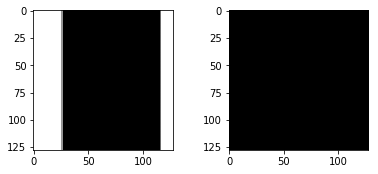

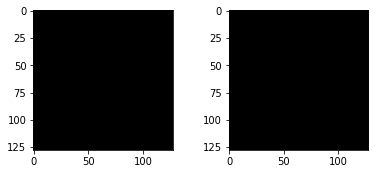

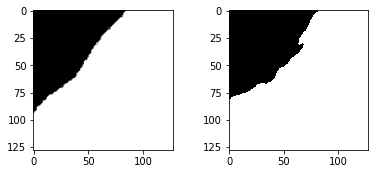

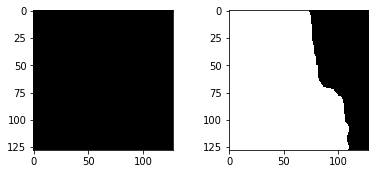

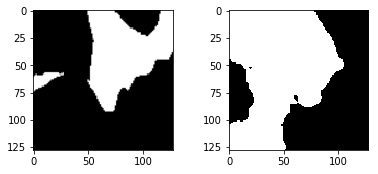

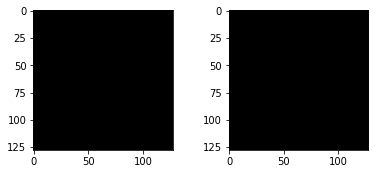

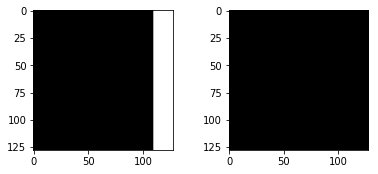

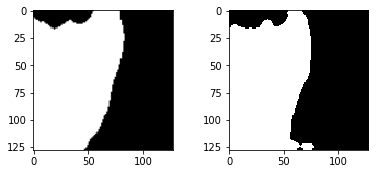

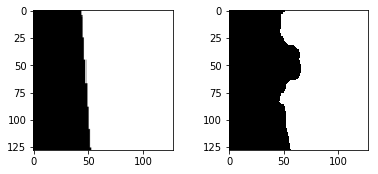

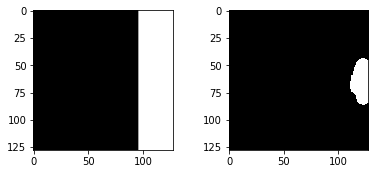

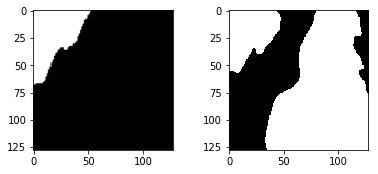

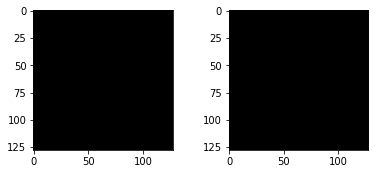

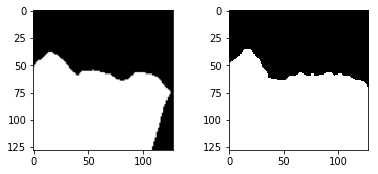

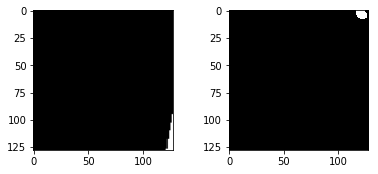

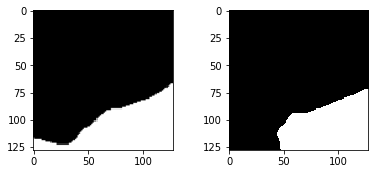

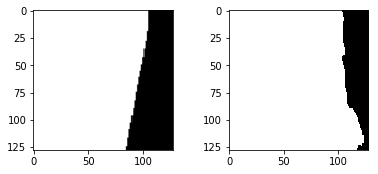

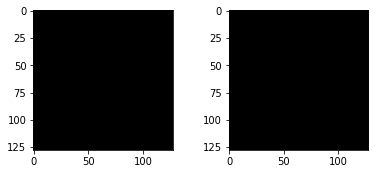

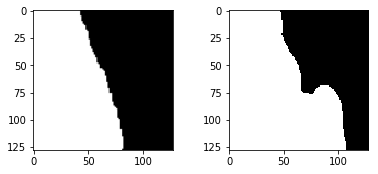

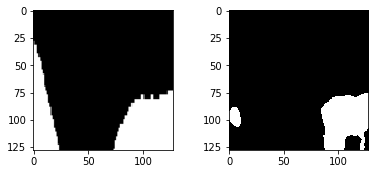

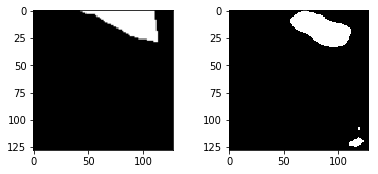

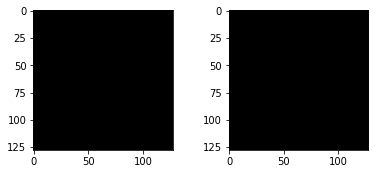

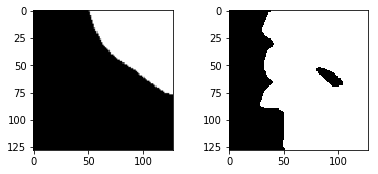

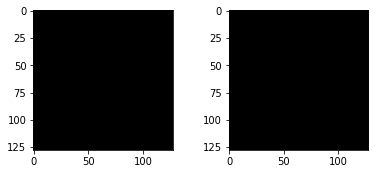

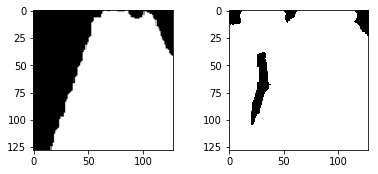

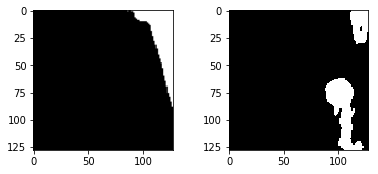

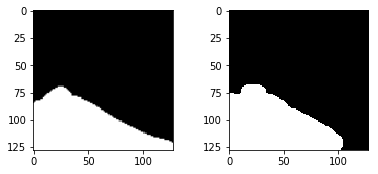

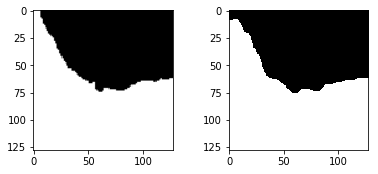

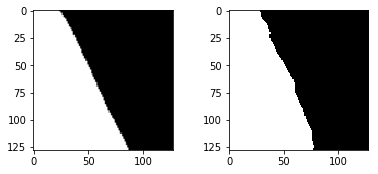

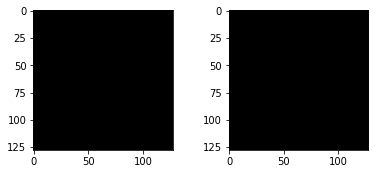

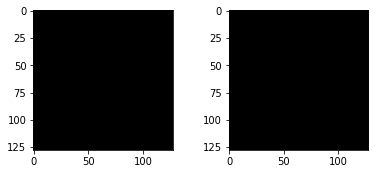

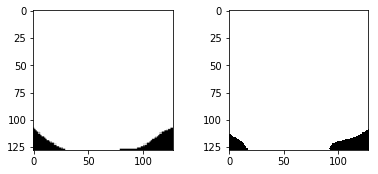

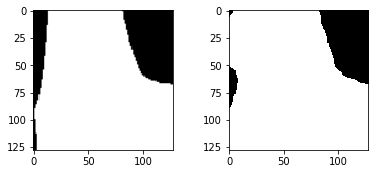

In [15]:
print("\n      Ground Truth            Predicted Value")

for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4
    
    for i in range(len(result)):
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")